## Computing native contacts with MDTraj

Using the definition from Best, Hummer, and Eaton, "Native contacts determine protein folding mechanisms in atomistic simulations" PNAS (2013) [10.1073/pnas.1311599110](http://dx.doi.org/10.1073/pnas.1311599110)

Eq. (1) of the SI defines the expression for the fraction of native contacts, $Q(X)$:

$$
Q(X) = \frac{1}{|S|} \sum_{(i,j) \in S} \frac{1}{1 + \exp[\beta(r_{ij}(X) - \lambda r_{ij}^0)]},
$$

where
 - $X$ is a conformation,
 - $r_{ij}(X)$ is the distance between atoms $i$ and $j$ in conformation $X$,
 - $r^0_{ij}$ is the distance from heavy atom i to j in the native state conformation,
 - $S$ is the set of all pairs of heavy atoms $(i,j)$ belonging to residues $\theta_i$ and $\theta_j$ such that $|\theta_i - \theta_j| > 3$ and $r^0_{i,} < 4.5 \unicode{x212B}$,
 - $\beta=5 \unicode{x212B}^{-1}$,
 - $\lambda=1.8$ for all-atom simulations

In [1]:
import numpy as np
import mdtraj as md
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 5  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 40  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    print(heavy)
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

In [2]:
# pull a random protein from the PDB
# (The unitcell info happens to be wrong)
#traj = md.load_pdb('http://www.rcsb.org/pdb/files/2MI7.pdb')
traj = md.load_xtc('mdnew_-30.xtc', stride=100, top='afp-native.pdb')

#print(traj[0])
# just for example, use the first frame as the 'native' conformation
q = best_hummer_q(traj, traj[0])
print(len(q))

#Write out the fraction of native contact to file
with open("afp.txt", "w") as file:
    for item in q:
        file.write(str(item) + "\n")

C:\Users\atanu\Anaconda3\lib\site-packages\mdtraj\formats\pdb\pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (ATOM      7  N   ALA     0      33.310  43.560  40.740  1.00  0.00           N  , ATOM      6  O   ACE     0      31.980  42.070  41.800  1.00  0.00           O  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))
C:\Users\atanu\Anaconda3\lib\site-packages\mdtraj\formats\pdb\pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (ATOM   1003  N   NAC    65      42.430  32.590  33.910  1.00  0.00           N  , ATOM   1002  O   ALA    65      43.800  31.310  32.750  1.00  0.00           O  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


[   0    4    5    6    8   10   14   15   16   18   20   23   24   25
   28   29   30   32   34   37   40   41   42   45   46   47   49   51
   55   56   57   59   61   64   66   67   68   70   72   74   78   82
   83   84   86   88   90   94   98   99  100  102  104  108  109  110
  112  114  117  118  119  122  123  124  126  128  131  134  135  136
  139  140  141  143  145  148  150  154  158  159  160  162  164  166
  169  173  177  178  179  180  182  185  188  191  192  193  195  197
  199  202  206  210  211  212  214  216  219  220  221  224  225  226
  228  230  232  234  238  239  240  242  244  248  249  250  252  254
  257  259  263  267  268  269  271  273  275  277  281  282  283  285
  287  290  292  296  300  301  302  304  306  308  312  316  317  318
  320  322  325  328  329  333  334  335  337  339  342  345  346  350
  351  352  354  356  359  362  365  367  368  371  374  375  376  378
  380  383  385  386  387  389  391  394  397  398  399  400  401  402
  404 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(q)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()

NameError: name 'q' is not defined

In [3]:
# pull a random protein from the PDB
# (The unitcell info happens to be wrong)
#traj = md.load_pdb('http://www.rcsb.org/pdb/files/2MI7.pdb')
traj = md.load_xtc('mdnew_-20.xtc', stride=100, top='afp-native.pdb')

#print(traj[0])
# just for example, use the first frame as the 'native' conformation
q1 = best_hummer_q(traj, traj[0])
print(len(q1))

#Write out the fraction of native contact to file
with open("afp.txt", "w") as file:
    for item in q1:
        file.write(str(item) + "\n")

[   0    4    5    6    8   10   14   15   16   18   20   23   24   25
   28   29   30   32   34   37   40   41   42   45   46   47   49   51
   55   56   57   59   61   64   66   67   68   70   72   74   78   82
   83   84   86   88   90   94   98   99  100  102  104  108  109  110
  112  114  117  118  119  122  123  124  126  128  131  134  135  136
  139  140  141  143  145  148  150  154  158  159  160  162  164  166
  169  173  177  178  179  180  182  185  188  191  192  193  195  197
  199  202  206  210  211  212  214  216  219  220  221  224  225  226
  228  230  232  234  238  239  240  242  244  248  249  250  252  254
  257  259  263  267  268  269  271  273  275  277  281  282  283  285
  287  290  292  296  300  301  302  304  306  308  312  316  317  318
  320  322  325  328  329  333  334  335  337  339  342  345  346  350
  351  352  354  356  359  362  365  367  368  371  374  375  376  378
  380  383  385  386  387  389  391  394  397  398  399  400  401  402
  404 

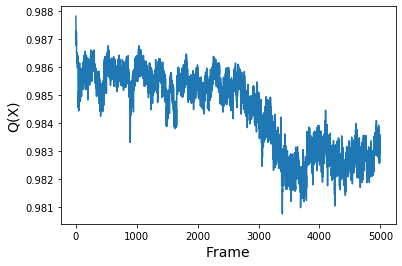

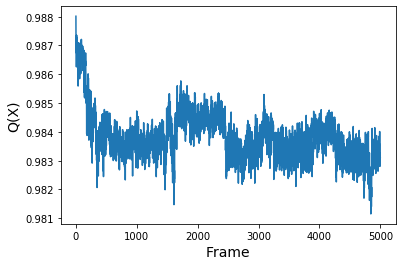

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(q)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()
plt.plot(q1)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()

In [50]:
import numpy as np
q20=q1
q30=q
q20, q30
h20 = [np.histogram(q20, bins=100, density=True)]
h30 = [np.histogram(q30, bins=100, density=True)]
type(h20[0])
print(h20[0][0])

[  2.91212869   0.           0.           2.91212869   5.82931754
   5.82425737   8.74397631   2.91212869   5.82425737   5.82931754
   8.73638606  23.29702948   8.74397631  14.56064343  17.48795263
  26.20915817  23.29702948  29.14658771  37.85767291  49.50618765
  72.86646928 122.30940479 128.24498593 174.72772112 218.4096514
 233.17270169 317.42202671 396.04950121 460.51608584 451.37994623
 599.89850919 559.61448405 652.31682552 658.71288227 608.63489524
 637.7561821  614.9930007  599.89850919 486.32549046 510.06528494
 454.29207492 486.74801478 477.5891044  393.13737253 352.6737113
 358.1918283  302.86138328 303.1245122  308.68564065 265.00371037
 332.27109991 270.82796774 247.74599554 165.99133507 139.7821769
 110.7570333   96.10024662  46.59405897  46.63454034  43.68193028
  46.63454034  23.29702948  17.47277211   5.82931754  11.64851474
   5.82425737   2.91465877  11.64851474  11.65863508  11.64851474
  11.64851474  11.65863508  20.3849008   11.64851474  20.4026114
  14.56064343 

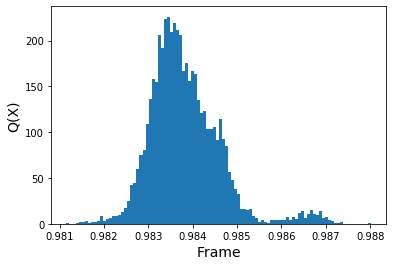

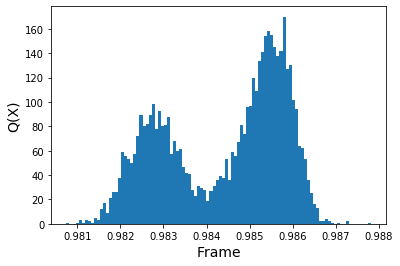

In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(q20, bins=100)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()
plt.hist(q30, bins=100)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()

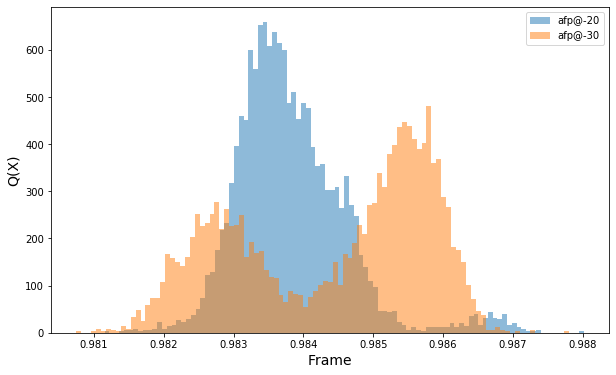

In [76]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(q20, bins=100, density=True, alpha=0.5, label='afp@-20')
plt.hist(q30, bins=100, density=True, alpha=0.5, label='afp@-30')
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.legend(loc='upper right')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

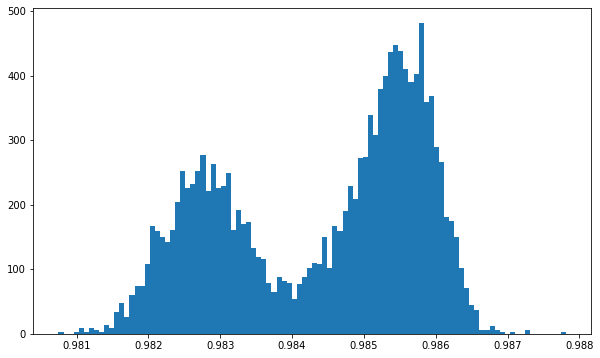

In [61]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
alpha, loc, beta=5, 100, 22
data=ss.gamma.rvs(alpha,loc=loc,scale=beta,size=5000)
myHist = plt.hist(q30, 100, density=True)
rv = ss.gamma(alpha,loc,beta)
x = np.linspace(0,600)
h = q30.plot(x, rv.pdf(x), lw=2)
# show
plt.show()